In [21]:
import os
import re
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
import joblib

In [22]:
def preprocess_nepali(text):
    # Keep only Devanagari (range: \u0900-\u097F) and whitespace
    text = re.sub(r'[^\u0900-\u097F\s]', '', text)
    # Remove extra spaces/newlines
    text = " ".join(text.split())
    return text

In [23]:
def preprocess_nepali(text):
    # Keep only Devanagari (range: \u0900-\u097F) and whitespace
    text = re.sub(r'[^\u0900-\u097F\s]', '', text)
    # Remove extra spaces/newlines
    text = " ".join(text.split())
    return text

# Load and clean in one loop
data = []
categories = [d for d in os.listdir('.') if os.path.isdir(d) and not d.startswith('.')]

for cat in categories:
    for file in os.listdir(cat):
        with open(os.path.join(cat, file), 'r', encoding='utf-8') as f:
            clean_text = preprocess_nepali(f.read())
            data.append({'text': clean_text, 'label': cat})

df = pd.DataFrame(data)
print(f"Dataset ready: {len(df)} samples across {len(categories)} categories.")

Dataset ready: 10000 samples across 10 categories.


In [24]:
import os

# 1. Count physical files on disk
disk_counts = {}
total_on_disk = 0

for cat in categories:
    if os.path.isdir(cat):
        file_list = [f for f in os.listdir(cat) if f.endswith('.txt')]
        disk_counts[cat] = len(file_list)
        total_on_disk += len(file_list)

# 2. Count rows in your DataFrame
df_counts = df['label'].value_counts().to_dict()

# 3. Compare
print(f"--- Verification Report ---")
print(f"Total files on disk: {total_on_disk}")
print(f"Total rows in DF:    {len(df)}")
print(f"\nBreakdown by Category (Disk vs DF):")
for cat in disk_counts:
    print(f"{cat:15}: Disk={disk_counts[cat]:<5} DF={df_counts.get(cat, 0)}")

--- Verification Report ---
Total files on disk: 10000
Total rows in DF:    10000

Breakdown by Category (Disk vs DF):
ArthaBanijya   : Disk=1000  DF=1000
Bichar         : Disk=1000  DF=1000
Desh           : Disk=1000  DF=1000
Khelkud        : Disk=1000  DF=1000
Manoranjan     : Disk=1000  DF=1000
Prabas         : Disk=1000  DF=1000
Sahitya        : Disk=1000  DF=1000
SuchanaPrabidhi: Disk=1000  DF=1000
Swasthya       : Disk=1000  DF=1000
Viswa          : Disk=1000  DF=1000


In [25]:
# Train/Test Split (80/20 is standard)
X_train, X_test, y_train, y_test = train_test_split(
    df['text'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
)

In [31]:
# 1. Improved Nepali stop words list (no duplicates)
nepali_stopwords = list(set([
    'र', 'को', 'मा', 'ले', 'छ', 'हो', 'पनि', 'छन्', 'थियो', 'भने', 'गरेका', 'गरेको', 'भएको', 
    'आयोजित', 'कार्यक्रम', 'सार्वजनिक', 'गरिएको', 'रहेका', 'तथा', 'साथै', 'लागि', 
    'भयो', 'गर्ने', 'हुने', 'गर्न', 'भएका'
]))

# 2. Vectorize with a Devanagari-friendly token pattern
vectorizer = TfidfVectorizer(
    max_features=15000, 
    stop_words=nepali_stopwords, # You can use the raw list now
    ngram_range=(1, 3), 
    max_df=0.7, 
    min_df=5,
    # This pattern says: "Catch any sequence of Devanagari characters" 
    # Unicode range for Devanagari is \u0900-\u097F
    token_pattern=r"[\u0900-\u097F]+" 
)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [32]:
print(f"Features created: {X_train_tfidf.shape[1]}")

Features created: 15000


In [33]:
# Initialize and Train
# Using 'cosine' distance is key for high-dimensional text data
knn = KNeighborsClassifier(n_neighbors=5, metric='cosine')
knn.fit(X_train_tfidf, y_train)

,"n_neighbors n_neighbors: int, default=5Number of neighbors to use by default for :meth:`kneighbors` queries.",5
,"weights weights: {'uniform', 'distance'}, callable or None, default='uniform'Weight function used in prediction. Possible values:- 'uniform' : uniform weights. All points in each neighborhood are weighted equally.- 'distance' : weight points by the inverse of their distance. in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.- [callable] : a user-defined function which accepts an array of distances, and returns an array of the same shape containing the weights.Refer to the example entitled:ref:`sphx_glr_auto_examples_neighbors_plot_classification.py`showing the impact of the `weights` parameter on the decisionboundary.",'uniform'
,"algorithm algorithm: {'auto', 'ball_tree', 'kd_tree', 'brute'}, default='auto'Algorithm used to compute the nearest neighbors:- 'ball_tree' will use :class:`BallTree`- 'kd_tree' will use :class:`KDTree`- 'brute' will use a brute-force search.- 'auto' will attempt to decide the most appropriate algorithm based on the values passed to :meth:`fit` method.Note: fitting on sparse input will override the setting ofthis parameter, using brute force.",'auto'
,"leaf_size leaf_size: int, default=30Leaf size passed to BallTree or KDTree. This can affect thespeed of the construction and query, as well as the memoryrequired to store the tree. The optimal value depends on thenature of the problem.",30
,"p p: float, default=2Power parameter for the Minkowski metric. When p = 1, this is equivalentto using manhattan_distance (l1), and euclidean_distance (l2) for p = 2.For arbitrary p, minkowski_distance (l_p) is used. This parameter is expectedto be positive.",2
,"metric metric: str or callable, default='minkowski'Metric to use for distance computation. Default is ""minkowski"", whichresults in the standard Euclidean distance when p = 2. See thedocumentation of `scipy.spatial.distance`_ andthe metrics listed in:class:`~sklearn.metrics.pairwise.distance_metrics` for valid metricvalues.If metric is ""precomputed"", X is assumed to be a distance matrix andmust be square during fit. X may be a :term:`sparse graph`, in whichcase only ""nonzero"" elements may be considered neighbors.If metric is a callable function, it takes two arrays representing 1Dvectors as inputs and must return one value indicating the distancebetween those vectors. This works for Scipy's metrics, but is lessefficient than passing the metric name as a string.",'cosine'
,"metric_params metric_params: dict, default=NoneAdditional keyword arguments for the metric function.",None
,"n_jobs n_jobs: int, default=NoneThe number of parallel jobs to run for neighbors search.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.Doesn't affect :meth:`fit` method.",None


In [34]:
# Predict
y_pred = knn.predict(X_test_tfidf)

In [35]:
joblib.dump(knn, 'nepali_news_knn.joblib')
joblib.dump(vectorizer, 'tfidf_vectorizer.joblib')

print("Artifacts saved as .joblib files.")

Artifacts saved as .joblib files.


In [37]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [38]:
# 1. Predict on the test set
y_pred = knn.predict(X_test_tfidf)

--- Classification Report ---
                 precision    recall  f1-score   support

   ArthaBanijya       0.75      0.89      0.82       200
         Bichar       0.74      0.87      0.80       200
           Desh       0.73      0.65      0.69       200
        Khelkud       0.95      0.98      0.97       200
     Manoranjan       0.71      0.72      0.72       200
         Prabas       0.80      0.67      0.73       200
        Sahitya       0.73      0.73      0.73       200
SuchanaPrabidhi       0.93      0.84      0.88       200
       Swasthya       0.85      0.94      0.89       200
          Viswa       0.86      0.74      0.80       200

       accuracy                           0.80      2000
      macro avg       0.81      0.80      0.80      2000
   weighted avg       0.81      0.80      0.80      2000



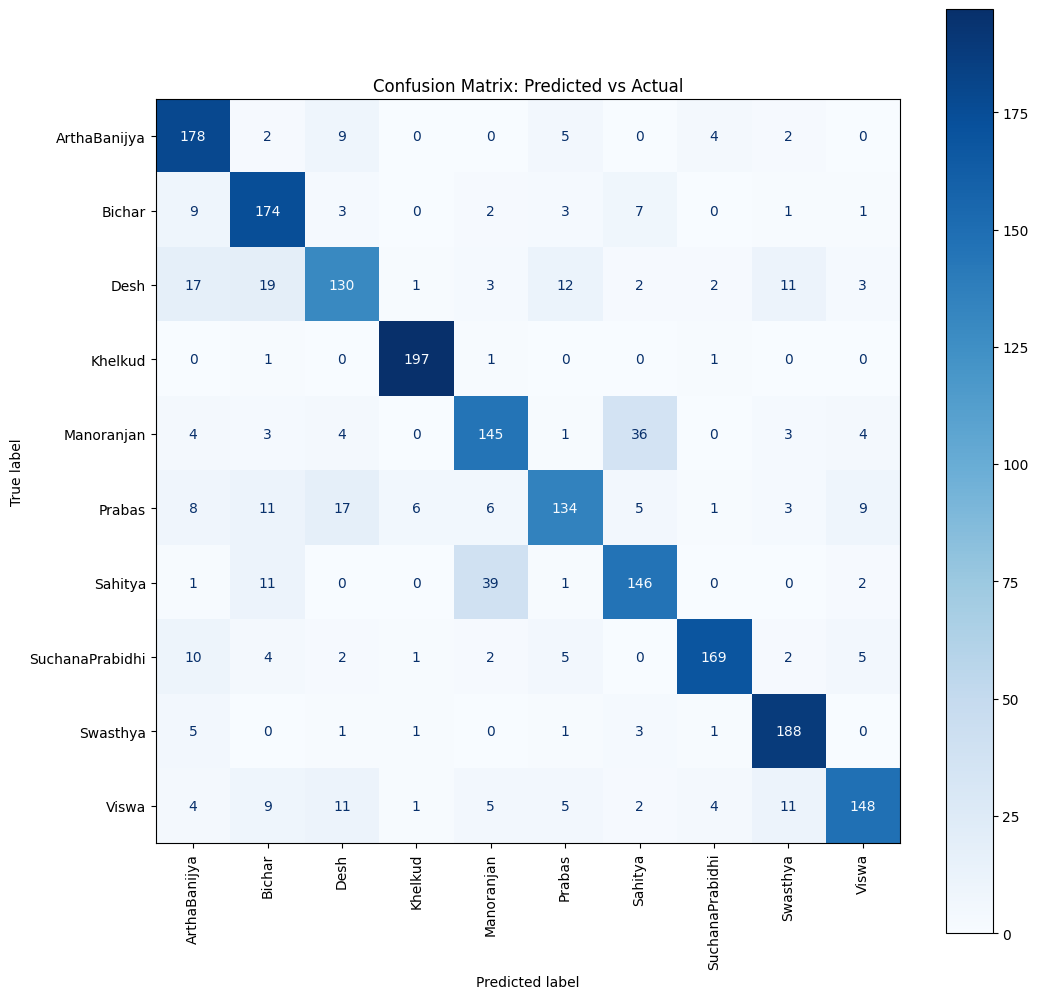

In [39]:
# 2. Print the text-based breakdown
print("--- Classification Report ---")
print(classification_report(y_test, y_pred))

# 3. Plot the Confusion Matrix using built-in sklearn tools
fig, ax = plt.subplots(figsize=(12, 12))
cmd = ConfusionMatrixDisplay.from_predictions(
    y_test, 
    y_pred, 
    display_labels=knn.classes_, 
    xticks_rotation='vertical',
    cmap='Blues',
    ax=ax
)

plt.title('Confusion Matrix: Predicted vs Actual')
plt.show()